In [52]:
import numpy as np
import pandas as pd
import scipy as sc
from scipy.stats import randint,norm,multivariate_normal, ortho_group
from scipy import linalg
from scipy.linalg import subspace_angles,orth
from scipy.optimize import fmin
from scipy import optimize
from scipy.optimize import minimize
import math
from statistics import mean, stdev ,variance
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import itertools as it
import matplotlib.pyplot as plt
!pip install spams
from google.colab import files
import sys



In [2]:
#@title ElasticNetSubspaceClustering Code
import warnings
import progressbar
import spams
import time

from scipy import sparse
from sklearn import cluster
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.decomposition import sparse_encode
from sklearn.linear_model import orthogonal_mp
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import normalize
from sklearn.utils import check_random_state, check_array, check_symmetric


class SelfRepresentation(BaseEstimator, ClusterMixin):

    def __init__(self, n_clusters=8, affinity='symmetrize', random_state=None, n_init=20, n_jobs=1):
        self.n_clusters = n_clusters
        self.affinity = affinity
        self.random_state = random_state
        self.n_init = n_init
        self.n_jobs = n_jobs

    def fit(self, X, y=None):
        X = check_array(X, accept_sparse=['csr', 'csc', 'coo'], dtype=np.float64)
        time_base = time.time()
        
        self._self_representation(X)
        self.timer_self_representation_ = time.time() - time_base
        
        self._representation_to_affinity()
        self._spectral_clustering()
        self.timer_time_ = time.time() - time_base

        return self
	
    def fit_self_representation(self, X, y=None):
        X = check_array(X, accept_sparse=['csr', 'csc', 'coo'], dtype=np.float64)
        time_base = time.time()
        
        self._self_representation(X)
        self.timer_self_representation_ = time.time() - time_base
        
        return self

    def _representation_to_affinity(self):
        normalized_representation_matrix_ = normalize(self.representation_matrix_, 'l2')
        if self.affinity == 'symmetrize':
            self.affinity_matrix_ = 0.5 * (np.absolute(normalized_representation_matrix_) + np.absolute(normalized_representation_matrix_.T))
        elif self.affinity == 'nearest_neighbors':
            neighbors_graph = kneighbors_graph(normalized_representation_matrix_, 3, 
		                                       mode='connectivity', include_self=False)
            self.affinity_matrix_ = 0.5 * (neighbors_graph + neighbors_graph.T)

    def _spectral_clustering(self):
        affinity_matrix_ = check_symmetric(self.affinity_matrix_)
        random_state = check_random_state(self.random_state)
        
        laplacian = sparse.csgraph.laplacian(affinity_matrix_, normed=True)
        _, vec = sparse.linalg.eigsh(sparse.identity(laplacian.shape[0]) - laplacian, 
                                     k=self.n_clusters, sigma=None, which='LA')
        embedding = normalize(vec)
        _, self.labels_, _ = cluster.k_means(embedding, self.n_clusters, 
                                             random_state=random_state, n_init=self.n_init)


def active_support_elastic_net(X, y, alpha, tau=1.0, algorithm='spams', support_init='knn', 
                               support_size=100, maxiter=40):
    n_samples = X.shape[0]

    if n_samples <= support_size:  # skip active support search for small scale data
        supp = np.arange(n_samples, dtype=int)  # this results in the following iteration to converge in 1 iteration
    else:    
        if support_init == 'L2':
            L2sol = np.linalg.solve(np.identity(y.shape[1]) * alpha + np.dot(X.T, X), y.T)
            c0 = np.dot(X, L2sol)[:, 0]
            supp = np.argpartition(-np.abs(c0), support_size)[0:support_size]
        elif support_init == 'knn':
            supp = np.argpartition(-np.abs(np.dot(y, X.T)[0]), support_size)[0:support_size]

    curr_obj = float("inf")
    for _ in range(maxiter):
        Xs = X[supp, :]
        if algorithm == 'spams':
            cs = spams.lasso(np.asfortranarray(y.T), D=np.asfortranarray(Xs.T), 
                             lambda1=tau*alpha, lambda2=(1.0-tau)*alpha)
            cs = np.asarray(cs.todense()).T
        else:
            cs = sparse_encode(y, Xs, algorithm=algorithm, alpha=alpha)
      
        delta = (y - np.dot(cs, Xs)) / alpha
		
        obj = tau * np.sum(np.abs(cs[0])) + (1.0 - tau)/2.0 * np.sum(np.power(cs[0], 2.0)) + alpha/2.0 * np.sum(np.power(delta, 2.0))
        if curr_obj - obj < 1.0e-10 * curr_obj:
            break
        curr_obj = obj
			
        coherence = np.abs(np.dot(delta, X.T))[0]
        coherence[supp] = 0
        addedsupp = np.nonzero(coherence > tau + 1.0e-10)[0]
        
        if addedsupp.size == 0:  # converged
            break

        # Find the set of nonzero entries of cs.
        activesupp = supp[np.abs(cs[0]) > 1.0e-10]  
        
        if activesupp.size > 0.8 * support_size:  # this suggests that support_size is too small and needs to be increased
            support_size = min([round(max([activesupp.size, support_size]) * 1.1), n_samples])
        
        if addedsupp.size + activesupp.size > support_size:
            ord = np.argpartition(-coherence[addedsupp], support_size - activesupp.size)[0:support_size - activesupp.size]
            addedsupp = addedsupp[ord]
        
        supp = np.concatenate([activesupp, addedsupp])
    
    c = np.zeros(n_samples)
    c[supp] = cs
    return c

  
def elastic_net_subspace_clustering(X, gamma=50.0, gamma_nz=True, tau=1.0, algorithm='lasso_lars', 
                                    active_support=True, active_support_params=None, n_nonzero=50):
    if algorithm in ('lasso_lars', 'lasso_cd') and tau < 1.0 - 1.0e-10:  
        warnings.warn('algorithm {} cannot handle tau smaller than 1. Using tau = 1'.format(algorithm))
        tau = 1.0
		
    if active_support == True and active_support_params == None:
        active_support_params = {}

    n_samples = X.shape[0]
    rows = np.zeros(n_samples * n_nonzero)
    cols = np.zeros(n_samples * n_nonzero)
    vals = np.zeros(n_samples * n_nonzero)
    curr_pos = 0
 
    for i in progressbar.progressbar(range(n_samples)):
        y = X[i, :].copy().reshape(1, -1)
        X[i, :] = 0
        
        if algorithm in ('lasso_lars', 'lasso_cd', 'spams'):
            if gamma_nz == True:
                coh = np.delete(np.absolute(np.dot(X, y.T)), i)
                alpha0 = np.amax(coh) / tau  # value for which the solution is zero
                alpha = alpha0 / gamma
            else:
                alpha = 1.0 / gamma

            if active_support == True:
                c = active_support_elastic_net(X, y, alpha, tau, algorithm, **active_support_params)
            else:
                if algorithm == 'spams':
                    c = spams.lasso(np.asfortranarray(y.T), D=np.asfortranarray(X.T), 
                                    lambda1=tau * alpha, lambda2=(1.0-tau) * alpha)
                    c = np.asarray(c.todense()).T[0]
                else:
                    c = sparse_encode(y, X, algorithm=algorithm, alpha=alpha)[0]
        else:
          warnings.warn("algorithm {} not found".format(algorithm))
	    	  
        index = np.flatnonzero(c)
        if index.size > n_nonzero:
        #  warnings.warn("The number of nonzero entries in sparse subspace clustering exceeds n_nonzero")
          index = index[np.argsort(-np.absolute(c[index]))[0:n_nonzero]]
        rows[curr_pos:curr_pos + len(index)] = i
        cols[curr_pos:curr_pos + len(index)] = index
        vals[curr_pos:curr_pos + len(index)] = c[index]
        curr_pos += len(index)
        
        X[i, :] = y

#   affinity = sparse.csr_matrix((vals, (rows, cols)), shape=(n_samples, n_samples)) + sparse.csr_matrix((vals, (cols, rows)), shape=(n_samples, n_samples))
    return sparse.csr_matrix((vals, (rows, cols)), shape=(n_samples, n_samples))
class ElasticNetSubspaceClustering(SelfRepresentation):
    def __init__(self, n_clusters=8, affinity='symmetrize', random_state=None, n_init=20, n_jobs=1, gamma=50.0, gamma_nz=True, tau=1.0, 
                 algorithm='lasso_lars', active_support=True, active_support_params=None, n_nonzero=50):
        self.gamma = gamma
        self.gamma_nz = gamma_nz
        self.tau = tau
        self.algorithm = algorithm
        self.active_support = active_support
        self.active_support_params = active_support_params
        self.n_nonzero = n_nonzero

        SelfRepresentation.__init__(self, n_clusters, affinity, random_state, n_init, n_jobs)
    
    def _self_representation(self, X):
        self.representation_matrix_ = elastic_net_subspace_clustering(X, self.gamma, self.gamma_nz, 
                                                                      self.tau, self.algorithm, 
		                                                              self.active_support, self.active_support_params, 
		                                                              self.n_nonzero)
					

def sparse_subspace_clustering_orthogonal_matching_pursuit(X, n_nonzero=10, thr=1.0e-6):
    n_samples = X.shape[0]
    rows = np.zeros(n_samples * n_nonzero, dtype = int)
    cols = np.zeros(n_samples * n_nonzero, dtype = int)
    vals = np.zeros(n_samples * n_nonzero)
    curr_pos = 0

    for i in progressbar.progressbar(range(n_samples)):
    # for i in range(n_samples):
        residual = X[i, :].copy()  # initialize residual
        supp = np.empty(shape=(0), dtype = int)  # initialize support
        residual_norm_thr = np.linalg.norm(X[i, :]) * thr
        for t in range(n_nonzero):  # for each iteration of OMP  
            # compute coherence between residuals and X     
            coherence = abs( np.matmul(residual, X.T) )
            coherence[i] = 0.0
            # update support
            supp = np.append(supp, np.argmax(coherence))
            # compute coefficients
            c = np.linalg.lstsq( X[supp, :].T, X[i, :].T, rcond=None)[0]
            # compute residual
            residual = X[i, :] - np.matmul(c.T, X[supp, :])
            # check termination
            if np.sum(residual **2) < residual_norm_thr:
                break

        rows[curr_pos:curr_pos + len(supp)] = i
        cols[curr_pos:curr_pos + len(supp)] = supp
        vals[curr_pos:curr_pos + len(supp)] = c
        curr_pos += len(supp)

#   affinity = sparse.csr_matrix((vals, (rows, cols)), shape=(n_samples, n_samples)) + sparse.csr_matrix((vals, (cols, rows)), shape=(n_samples, n_samples))
    return sparse.csr_matrix((vals, (rows, cols)), shape=(n_samples, n_samples))
					

class SparseSubspaceClusteringOMP(SelfRepresentation):
    def __init__(self, n_clusters=8, affinity='symmetrize', random_state=None, n_init=10, n_jobs=1, n_nonzero=10, thr=1.0e-6):
        self.n_nonzero = n_nonzero
        self.thr = thr
        SelfRepresentation.__init__(self, n_clusters, affinity, random_state, n_init, n_jobs)
    
    def _self_representation(self, X):
        self.representation_matrix_ = sparse_subspace_clustering_orthogonal_matching_pursuit(X, self.n_nonzero, self.thr)


def least_squares_subspace_clustering(X, gamma=10.0, exclude_self=False):
    n_samples, n_features = X.shape
  
    if exclude_self == False:
        if n_samples < n_features:
            gram = np.matmul(X, X.T)
            return np.linalg.solve(gram + np.eye(n_sample) / gamma, gram).T
        else:
            tmp = np.linalg.solve(np.matmul(X.T, X) + np.eye(n_features) / gamma, X.T)
            return np.matmul(X, tmp).T
    else:
        if n_samples < n_features:
            D = np.linalg.solve(np.matmul(X, X.T) + np.eye(n_sample) / gamma, np.eye(n_sample))  
            # see Theorem 6 in https://arxiv.org/pdf/1404.6736.pdf
        else:
            tmp = np.linalg.solve(np.matmul(X.T, X) + np.eye(n_features) / gamma, X.T)
            D = eye(n_samples) - np.matmul(X, tmp)
        D = D / D.diagonal()[None,:]
        np.fill_diagonal(D, 0.0)
        return -1.0 * D.T
class LeastSquaresSubspaceClustering(SelfRepresentation):
    def __init__(self, n_clusters=8, affinity='symmetrize', random_state=None, n_init=None, n_jobs=1, gamma=10.0, exclude_self=False):
        self.gamma = gamma
        self.exclude_self = exclude_self
        SelfRepresentation.__init__(self, n_clusters, affinity, random_state, n_init, n_jobs)
    
    def _self_representation(self, X):
        self.representation_matrix_ = least_squares_subspace_clustering(X, self.gamma, self.exclude_self)        
   

# 1. Simulation Study, Noiseless case. Simulate data according to the model above with the following parameters:
- n = 2^3,2^4,...,2^10.
- p = 2^4,2^5,2^6,2^ d 7.
- d = 2^(−1)p, 2^(−2)p, 2^(−3)p,2^(−4)p, for each of the values of p.
- K = 4 clusters.
- θ = 10^(−2)θmax, 10^(−1)θmax, θmax, where θmax is the value obtained on average by taking the different subspaces Bi to have uniformly random orientations

In [3]:
#for each subspace K unit vectors in random directions forming a basis
def first_simulatin(p,dim,k):
  b = [orth(np.random.randn(p, dim)) for k in range(k+1)]
  return (b)


#This yields an average pairwise angle denote θmax which depends on the dimensions p and d
def find_theta_max(p,dim):
  theta_max = []
  for i in range(100): 
    rand_subspac1 = orth(np.random.randn(p, dim))
    rand_subspac2 = orth(np.random.randn(p, dim))
    theta_max.append(subspace_angles(rand_subspac1,rand_subspac2).max())  #using min or max 
  max_avg_theta = np.average(theta_max)
  return(max_avg_theta)

#Then, replace each Bi by a linear combination Bi ← αBi + (1 − α)B0 where α ∈ (0, 1) is calibrated to yield average pairwise angle θ
def second_simulation(p,k,dim,theta,b) :
  def find_a_for_theta(a,p=p, dim=dim,theta = theta) :
    temp_theta = []
    for i in range(100): 
      rand_subspac0 = orth(np.random.randn(p, dim))
      rand_subspac1 = orth(np.random.randn(p, dim))
      rand_subspac2 = orth(np.random.randn(p, dim))
      temp_theta.append(subspace_angles(rand_subspac0*(1-a)+rand_subspac1*a,rand_subspac0*(1-a)+rand_subspac2*a).max())
    return (np.average(temp_theta)-theta)
  a= sc.optimize.bisect(find_a_for_theta,0,1)
  B = [b[0]*(1-a)+b[i]*a for i in range(1,k+1)]
  return (B)

# consider the following generative model for the data: zi ∼ U({1, .., K}), wi ∼ N(0, Id), xi|zi, wi ∼ N(Bziwi, σ2Ip) 
def third_simulation(n,p,dim,B,k,theta) :
  z = np.random.randint(0,k,n)  
  w = np.random.multivariate_normal(mean = np.zeros(dim),cov =np.diag(np.ones(dim)),size=n)
  X= np.zeros((n,p))
  for i in range(n):
    X[i,] = np.random.multivariate_normal(mean = np.array(np.dot(np.matrix(w[i,:]),B[z[i]].T)).flatten(),cov = np.diag(0.5*np.ones(p)))  #sigma value is missing/ change  
  return (n,p,dim,theta,X,z,B)


In [7]:
#data simulation
def final_data_simulation(k) :
  nn = [2 ** j for j in range(3,11)]
  pp = [2 ** j for j in range(4,8)]   
  dd = [2 ** -j for j in range(1,5)] 
  tt = [10 ** -j for j in range(0,3)] 
  df = pd.DataFrame(columns=['n', 'p', 'dim','theta','X','z','B'])
  for p in pp: 
    for d in dd:
      dim = int(d*p)
      b= first_simulatin(p=p,dim=dim,k=k)
      for t in tt :
        theta= find_theta_max(p=p,dim=dim)*t
        if (t==1) :
          a=1
          B = [b[0]*(1-a)+b[i]*a for i in range(1,k+1)]
        else :
          B= second_simulation(p,k,dim,theta,b)
        for n in nn: 
          row=pd.Series(list(third_simulation(n=n,p=p,dim=dim,B=B,k=k,theta=theta)[0:7]),["n","p","dim","theta","X","z","B"])
          df= df.append([row],ignore_index=True)
  return (df)



## **Clustering and subspacing: **
You should pick one of the algorithms above (ENsc) in additon to the naive K-mean

In [4]:
#. After Algorithm (kmean and additional) clustering, which yields cluster identities ˆz1, .., zˆn,we estimate the sub-space of each cluster k by performing PCA on 
#the points in this clusterand keeping the top d components as a basis for Bˆk for k = 1, ..,
def pca_subspace(df,i,dim):
  df_new= df[df['cluster']==i].drop(['cluster'],axis=1)
  pca_components_number = len(df_new)-1 if len(df_new)<dim  else dim #It is possible to get clusters of size smaller than d. you can for a generic cluster of m points, take the
#unique sub-space of dimension m−1 passing through these points, and get a subspace with dimension less than d.
  pca = PCA(n_components=pca_components_number)
  pca.fit_transform(df_new)
  B_kmeans = pca.components_
  return (B_kmeans.T)

# apply kmeans 
def find_kmeans_subspace(X,k,dim):
  kmeans = KMeans(n_clusters=k)
  temp_df = pd.DataFrame(X)
  temp_df['cluster'] = kmeans.fit_predict(X)
  B_kmean = [pca_subspace(temp_df,i,dim) for i in range(k)]
  cluster_kmean = temp_df['cluster']
  return  (B_kmean,cluster_kmean)

#apply ensc 
def find_ensc_subspace(X,k,dim):
  temp_df = pd.DataFrame(X)
  temp_df['cluster']  = ElasticNetSubspaceClustering(n_clusters=k).fit(X).labels_
                                                     #,algorithm='lasso_lars',gamma=50)  #learn about model parameters
  B_ensc = [pca_subspace(temp_df,i,dim) for i in range(k)]
  cluster_ensc = temp_df['cluster'] 
  return (B_ensc, cluster_ensc)

# **recovery performan**
we seek good agreement between the true subspaces and the recovered subspaces. Since we can at best recover the correct subspaces up to a permutation, we enumerate over all 
possible permutations π ∈ SK, where Sk is the group of permutations over K elements, and take the best.


In [12]:

#The cost measures the angle between the original and estimated sub-spaces,with higher values achieved for smaller angle
def performance_measure1(k,B1,B2): 
  all_per = list(it.permutations(range(k)))
  sum_cos_angles_all_per = np.zeros(len(all_per))
  for l, val in enumerate(all_per):
    for i in range(k) : 
      if B2[val[i]].shape[1]>0 : # handling with empty clusters
        sum_cos_angles_all_per[l]+= (math.cos(subspace_angles(B1[i],B2[val[i]]).max()))**2   #use min or max????????????????
  cost_subspace = sum_cos_angles_all_per.max()
  return (cost_subspace)

  # WHAT ARE WE DOING WITH EMPTY CLUSTERS 
# The cost in measures the fraction of points clustered correctly:
def performance_measure2(k,cluster1,cluster2):
  data = {'cluster1': cluster1,'cluster2': cluster2} 
  clusters = pd.DataFrame(data, index=range(len(cluster1)))
  all_per = list(it.permutations(range(k)))
  accuracy_rate_all_per = np.zeros(len(all_per))
  for l, per in enumerate(all_per) :
    c = [i for i in range(k)]
    dic = dict(zip(c,per))
    clusters['premut_cluster'] = clusters['cluster2'].transform(lambda x: dic[x] if x in dic else None)
    m = clusters.groupby(['cluster1','premut_cluster']).size().unstack(fill_value=0)
    accuracy_rate_all_per[l]=np.trace(m)
  cost_cluster = (accuracy_rate_all_per.max())/len(cluster1) 
  return (cost_cluster)   


In [8]:
def all_process(k): 
    df = final_data_simulation(k)
    kmean_resluts = df.apply(lambda x: find_kmeans_subspace(x['X'], k, x['dim']), axis=1)
    df['B_kmean'] = [pair[0] for pair in kmean_resluts]
    df['cluster_kmean']  = [pair[1] for pair in kmean_resluts]
    ensc_resluts = df.apply(lambda x: find_ensc_subspace(x['X'], k, x['dim']), axis=1)
    df['B_ensc'] = [pair[0] for pair in ensc_resluts]
    df['cluster_ensc']  = [pair[1] for pair in ensc_resluts]
    return (df)

In [ ]:
#apply algorithm 
measure1_kmean = pd.DataFrame()
measure2_kmean = pd.DataFrame()
measure1_ensc =  pd.DataFrame()
measure2_ensc =  pd.DataFrame()
k = 4 
for iter in range(5) :
  df = all_process(k)
  measure1_kmean.insert(iter, "", df.apply (lambda x: performance_measure1(k, x['B'], x['B_kmean']), axis=1), True) 
  measure2_kmean.insert(iter, "", df.apply(lambda x: performance_measure2(k, x['z'], x['cluster_kmean']), axis=1), True)
  measure1_ensc.insert(iter, "", df.apply(lambda x: performance_measure1(k, x['B'], x['B_ensc']), axis=1), True) 
  measure2_ensc.insert(iter, "", df.apply(lambda x: performance_measure2(k, x['z'], x['cluster_ensc']), axis=1), True) 
df['measure1_kmean'] = measure1_kmean.apply(lambda x: mean(x), axis=1)
df['measure2_kmean'] = measure2_kmean.apply(lambda x: mean(x), axis=1)
df['measure1_ensc'] = measure1_ensc.apply(lambda x: mean(x), axis=1)
df['measure2_ensc'] = measure2_ensc.apply(lambda x: mean(x), axis=1)
df['theta_degree'] = df.apply(lambda x: math.degrees(x['theta']), axis=1)
df['t'] = list(np.repeat(np.array([1,1/10,1/100]), [8,8,8],axis=0))*16
df['theta_degree'] = round(df['theta_degree'],2)
df.to_csv('q1_df14.csv')
files.download('q1_df14.csv')
df.head()



In [33]:
df2.to_csv('q1_df13.csv')
files.download('q1_df13.csv')
df2.head()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,p,dim,theta,t,0,d\p,n_q
0,16,1,0.013675,0.01,8,0.0625,18
1,16,1,0.135263,0.10,8,0.0625,7
2,16,1,1.373599,1.00,8,0.0625,18
3,16,2,0.014247,0.01,8,0.1250,18
4,16,2,0.144667,0.10,8,0.1250,10


In [ ]:
#@title Default title text
if 'google.colab' in sys.modules:
    uploaded = files.upload()
df = pd.read_csv('q1_df12 (1).csv')
df['cluster_kmean']=df['cluster_kmean'].apply(lambda x: x.split('\n'))
df['cluster_ensc']=df['cluster_ensc'].apply(lambda x: x.split('\n'))
df['B_kmean']=df['B_kmean'].apply(lambda x: x.split('\n'))
df['B_ensc']=df['B_ensc'].apply(lambda x: x.split('\n'))


Saving q1_df12 (1).csv to q1_df12 (1).csv


## Visualization of recovery performance
For each of the two recovery performance measures, and for each
value of (p, d), make a heatmap showing performance as function of angle θ and
number of samples n

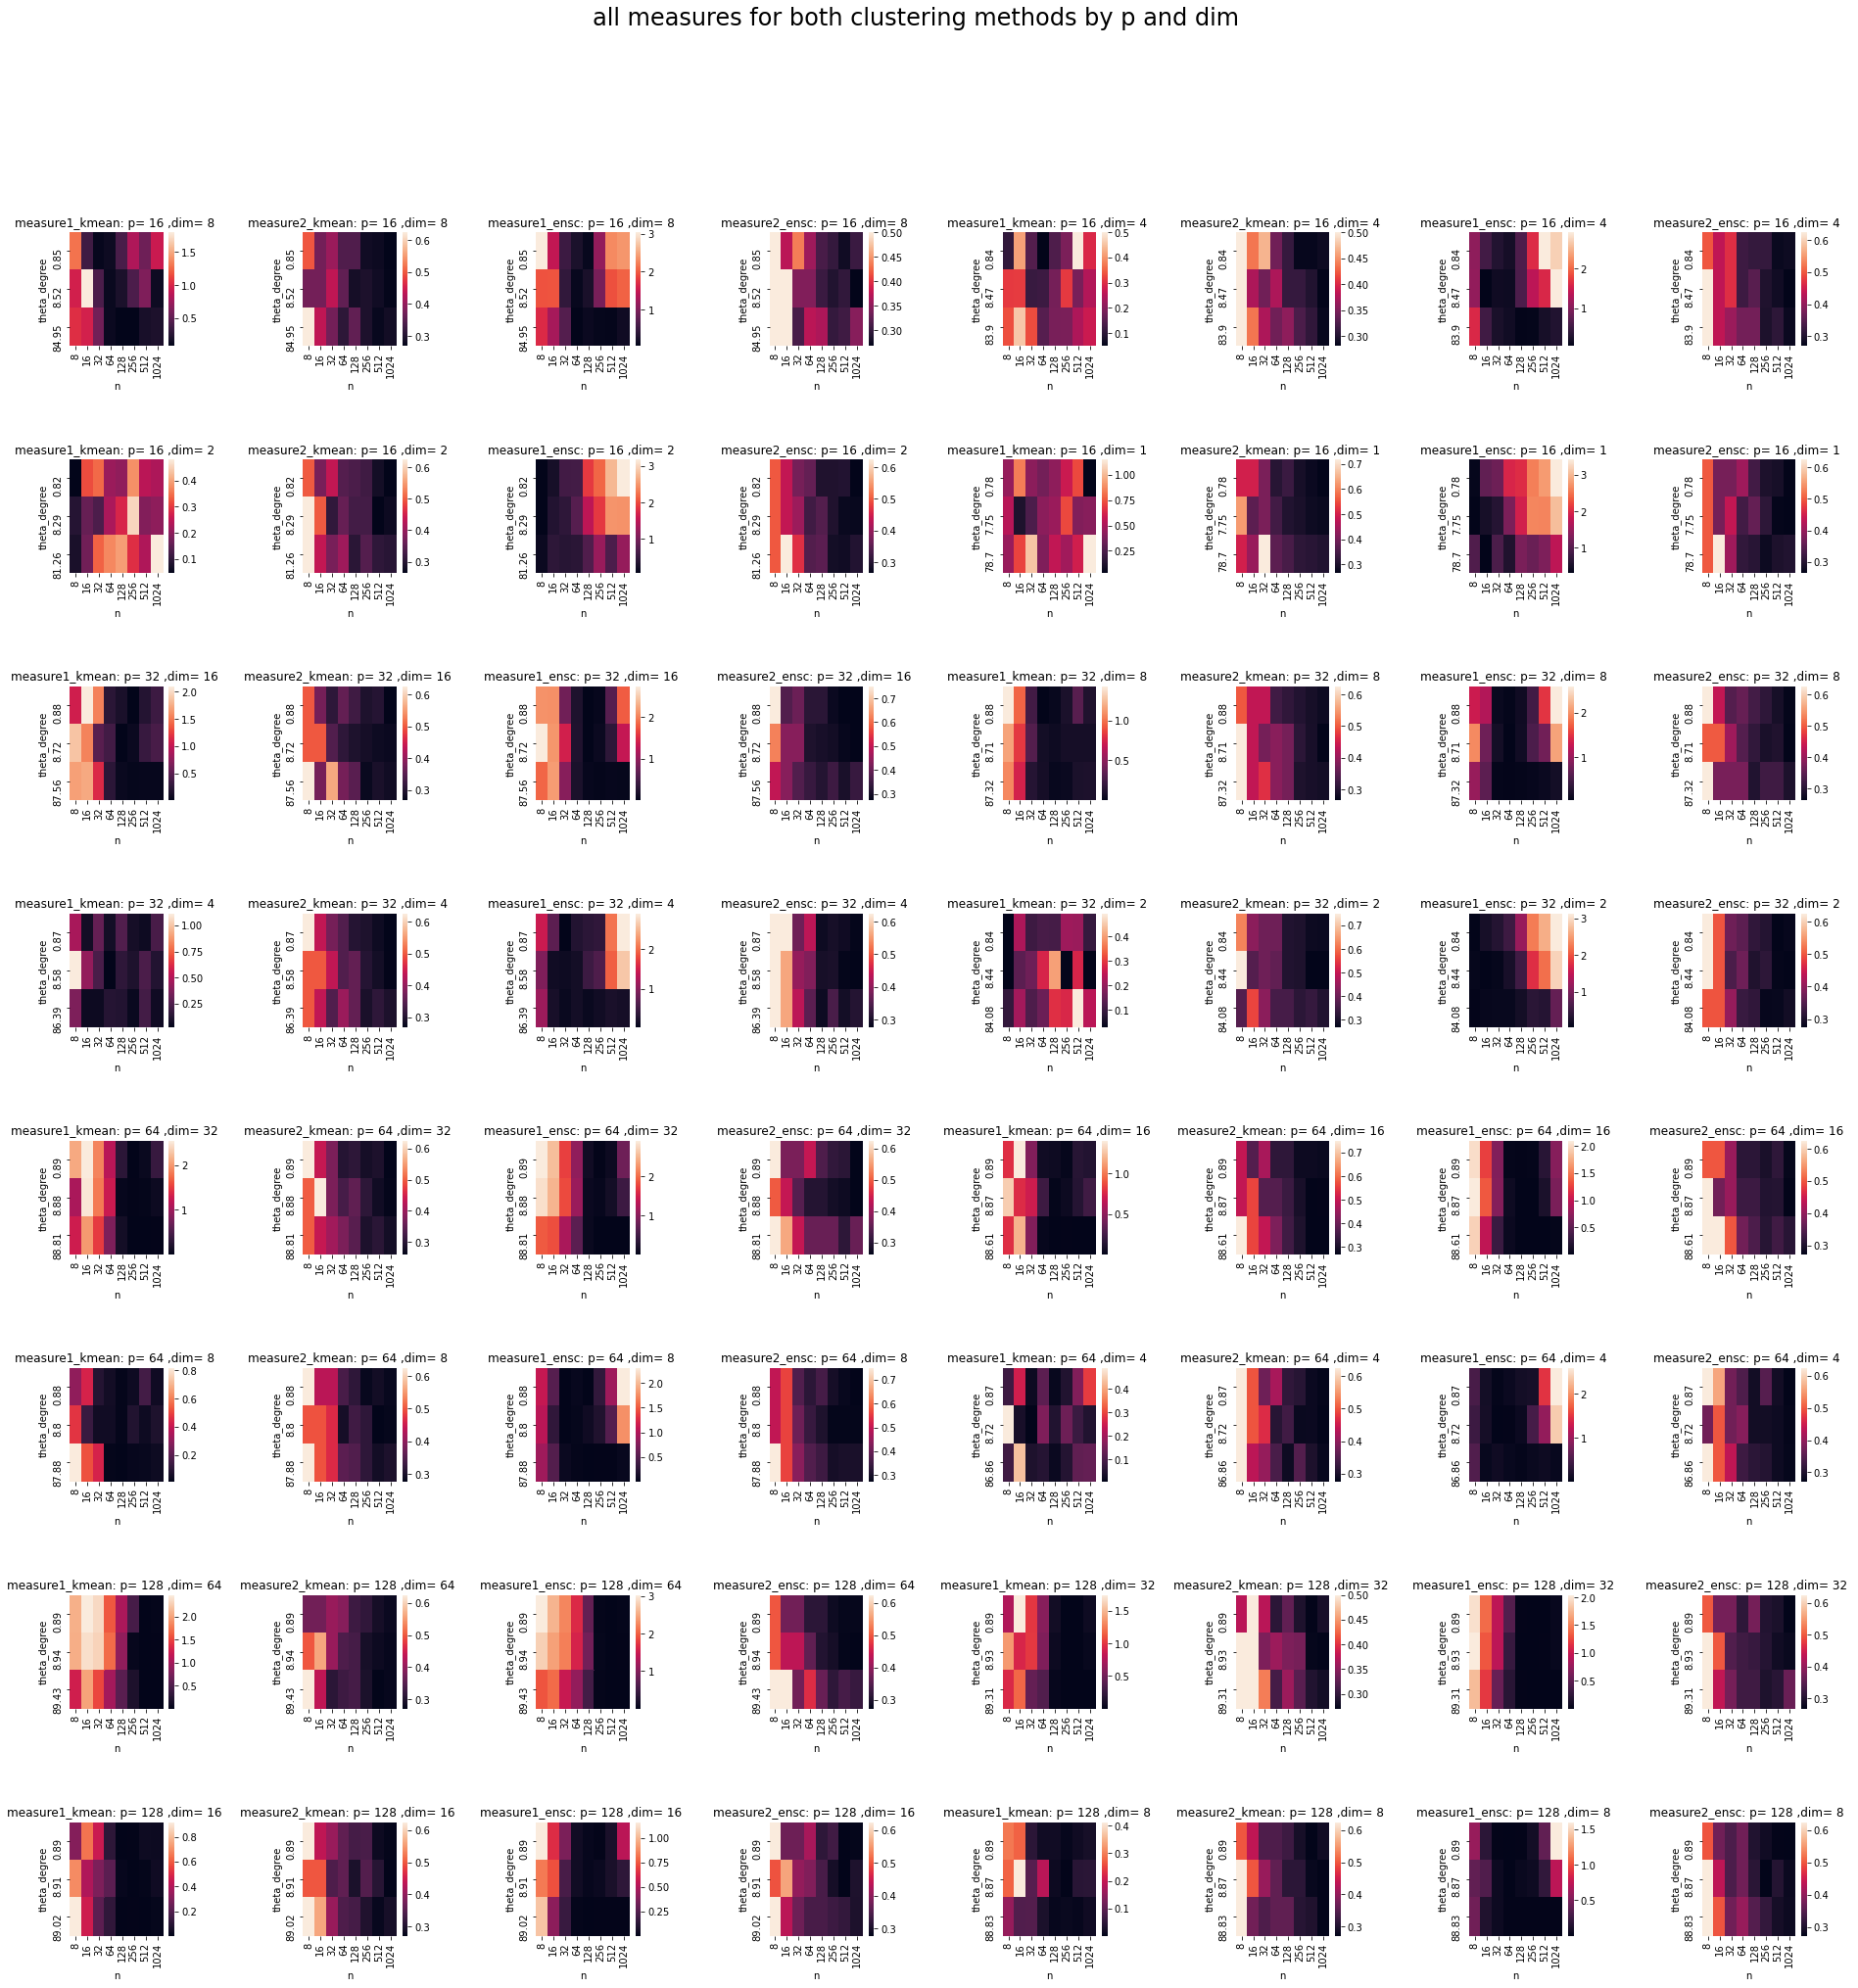

In [24]:
all_measurea = ["measure1_kmean","measure2_kmean","measure1_ensc","measure2_ensc"] 
fig, axes  = plt.subplots(8,8,sharex=False, sharey=False,figsize=(32,32))
fig.suptitle('all measures for both clustering methods by p and dim', fontsize=24)
pp = [2 ** j for j in range(4,8)]   
dd = [2 ** -j for j in range(1,5)]
i=0
j=0
for p in pp:
  for d in dd:
    dim = int(d*p)
    for measure in all_measurea:
      sns_df = df[(df['p']==p) & (df['dim']==dim)]
      sns_df = sns_df.pivot("theta_degree", "n", measure)
      sns.heatmap(sns_df,ax= axes[i,j])
      plt.subplots_adjust(wspace=1,hspace = 1)
      #counter = counter+1
      axes[i,j].set_title('{a}: p= {b} ,dim= {c} '.format(a=measure,b=p, c=dim),, fontsize=16)
      i= i if (j<7) else i+1
      j= j+1 if (j<7) else 0  



average accuracy for data simulated as function of n

In [27]:
  def find_accuracy_rate(n,p,dim,theta,k,iter,t): 
    accuracy_rate = [] 
    for r in range(iter):  
      b = first_simulatin(p,dim,k)
      if (t==1) :
          a=1
          B = [b[0]*(1-a)+b[i]*a for i in range(1,k+1)]
      else :
          B= second_simulation(p,k,dim,theta,b)
      z = np.random.randint(0,k,n)  
      w = np.random.multivariate_normal(mean = np.zeros(dim),cov =np.diag(np.ones(dim)),size=n)
      X= np.zeros((n,p))
      for i in range(n):
        X[i,] = np.random.multivariate_normal(mean = np.array(np.dot(np.matrix(w[i,:]),B[z[i]].T)).flatten(),cov = np.diag(0.5*np.ones(p)))  #sigma value is missing 
      ensc_results = find_ensc_subspace(X,k,dim)
      ensc_clusters = ensc_results[1]
      #kmeans_results = find_kmeans_subspace(X,k,dim)
      #kmeans_clusters = kmeans_results[1]
      #accuracy_rate.append(performance_measure2(k,z,kmeans_clusters))
      accuracy_rate.append(performance_measure2(k,z,ensc_clusters))
    avg_accuracy_rate = mean(accuracy_rate) 
    return (avg_accuracy_rate - 0.5 )

Estimate for each such configuration n0.5, i.e. the sample size required to cluster half
the points correctly

In [31]:
def binary_search(low,high,acc,p,dim,theta,k,iter,t): 
  mid = (high + low) // 2
  value = find_accuracy_rate(mid,p,dim,theta,k,iter,t)
  if value <= acc and value >=0 : 
    return mid 
  elif value <0: 
    return binary_search(low, mid - 1, acc,p,dim,theta,k,iter,t) 
  elif value >acc:
    return binary_search(mid + 1, high, acc,p,dim,theta,k,iter,t) 
  else: 
    return -1

In [ ]:
df2 = df.groupby(['p','dim','theta','t']).size().reset_index()
df2['d\p'] = df2['dim']/df2['p']
df2['n_q'] = np.repeat(0,len(df2))
for row_no in range(len(df2)): 
  df2['n_q'][row_no]= binary_search(4,500,0.1,df2['p'][row_no],df2['dim'][row_no],df2['theta'][row_no],4,5,df2['t'][row_no])



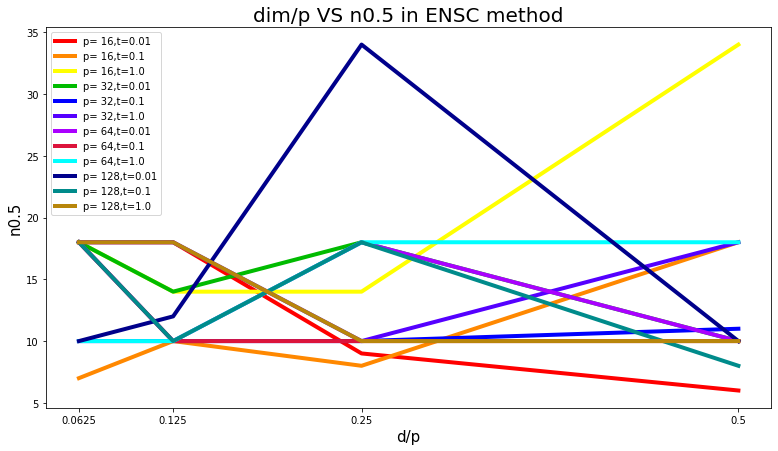

In [34]:
pp =  np.unique(df2['p'])
tt =  np.unique(df2['t'])
plt.figure(figsize=(13,7))
newcolors = ['#F00','#F80','#FF0','#0B0','#00F','#50F','#A0F','#DC143C','#00FFFF', '#00008B','#008B8B','#B8860B']
i=0 
for p in np.unique(df2['p']):
  for t in np.unique(df2['t']):
    plt_df = df2[(df2['p']==p) & (df2['t']==t)]
    plt.plot (plt_df['d\p'],plt_df['n_q'],linewidth=4.0, c=newcolors[i] , label="p= {a},t={b}".format(a=p, b=t))
    i= i+1
    plt.xlabel("d/p",size=15)
    plt.ylabel("n0.5",size=15)
    plt.title("dim/p VS n0.5 in ENSC method",size=20)
    plt.legend(loc='upper left')
    positions = (1/16,1/8,1/4,1/2)
    labels = ("0.0625", "0.125", "0.25","0.5")
    plt.xticks(positions, labels)





In [81]:

def find_b_constants(b_cons,df):
  optim_df = pd.DataFrame()
  for p in np.unique(df['p']):
    for t in np.unique(df['t']):
      n1,n2, n3, n4 = df['n_q'][(df['p']==p) & (df['t']==t)]
      sd = stdev([n1,n2,n3,n4])
      row=pd.Series([n1,n2,n3,n4,sd])
      optim_df= optim_df.append([row],ignore_index=False)
  optim_df['b_cons'] = b_cons
  new_df = optim_df.iloc[:,:4].apply(lambda x: (x-optim_df['b_cons'] )/optim_df.iloc[:,4],axis=0)
  #return (0 if (new_df.apply(lambda x: len(np.unique(round(x,2)))==1,axis=0)).all() else 1)
  #return new_df.apply(lambda x: len(np.unique(round(x,2)))==1,axis=0).sum()
  return new_df.apply(lambda x: variance(x), axis=0).sum()



In [80]:
sc.optimize.bisect(find_b_constants, a=np.repeat(df2['n_q'].min(),12), b= np.repeat(df2['n_q'].max(),12), args =(df2))

RuntimeError: ignored

In [91]:
f= minimize(find_b_constants, x0= np.random.randint(df2['n_q'].min(), df2['n_q'].max(), 12) ,args =(df2),method="Nelder-Mead")
xx=f['x']
xx

array([11.40717708, 10.01782517, 17.90882359, 14.53905089, 10.14615328,
       16.71127114, 10.63415172, 11.77975805, 13.05186279, 14.01365981,
       13.67039288, 12.95050168])

In [89]:
optim_df = pd.DataFrame()
for p in np.unique(df2['p']):
  for t in np.unique(df2['t']):
    n1,n2, n3, n4 = df2['n_q'][(df2['p']==p) & (df2['t']==t)]
    sd = stdev([n1,n2,n3,n4])
    row=pd.Series([n1,n2,n3,n4,sd])
    optim_df= optim_df.append([row],ignore_index=False)
optim_df['b_cons'] = xx
new_df = optim_df.iloc[:,:4].apply(lambda x: (x-optim_df['b_cons'] )/optim_df.iloc[:,4],axis=0)
new_df, new_df.apply(lambda x: variance(x), axis=0).sum()


(          0         1         2         3
 0  0.349923  0.349923 -1.105291 -1.590362
 0 -1.250145 -0.649143 -1.049811  0.953530
 0 -0.709000 -1.129084 -1.129084  0.971336
 0  0.284386 -0.760080  0.284386 -1.804546
 0 -0.998960 -0.998960 -0.998960  1.001040
 0  0.001033  0.001033 -1.998967  0.001033
 0  0.367030 -1.365020  0.367030 -1.365020
 0  1.001044 -0.998956 -0.998956 -0.998956
 0 -1.365010 -1.365010  0.367041  0.367041
 0 -1.054288 -0.883416  0.996170 -1.054288
 0  0.356582 -1.164356  0.356582 -1.544591
 0  0.367035  0.367035 -1.365016 -1.365016, 3.134710457455534)

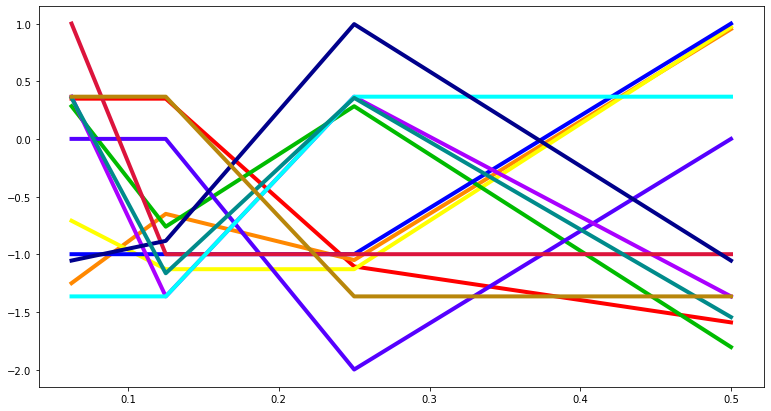

In [90]:
pp =  np.unique(df2['p'])
tt =  np.unique(df2['t'])
plt.figure(figsize=(13,7))
newcolors = ['#F00','#F80','#FF0','#0B0','#00F','#50F','#A0F',    '#DC143C','#00FFFF', '#00008B','#008B8B','#B8860B']

i=0 
for p in np.unique(df2['p']):
  for t in np.unique(df2['t']):
    plt_df = df2[(df2['p']==p) & (df2['t']==t)]
    normalized_n_q = (plt_df['n_q']-xx[i])/stdev(plt_df['n_q'])
    plt.plot (plt_df['d\p'],normalized_n_q,linewidth=4.0, c=newcolors[i] , label="p= {a},t={b}".format(a=p, b=t))

    i= i+1
    #plt.xlabel("d/p",size=15)
    #plt.ylabel("n0.5",size=15)
    #plt.title("dim/p VS n0.5 in ENSC method",size=20)
    #plt.legend(loc='upper left')
    #positions = (1/16,1/8,1/4,1/2)
    #labels = ("0.0625", "0.125", "0.25","0.5")
    #plt.xticks(positions, labels)
    